# Problem 9: GPT-2 Configuration - Interactive Notebook

Explore GPT-2 configurations and understand model scaling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import GPT2Config
# from problem import GPT2Config

plt.rcParams['figure.figsize'] = (14, 10)
print('Setup complete!')

Setup complete!


## Create Configurations for All Model Sizes

In [2]:
# Create all four GPT-2 model sizes
small = GPT2Config.gpt2_small()
medium = GPT2Config.gpt2_medium()
large = GPT2Config.gpt2_large()
xl = GPT2Config.gpt2_xl()

configs = {
    'Small (124M)': small,
    'Medium (355M)': medium,
    'Large (774M)': large,
    'XL (1.5B)': xl,
}

# Print configuration summary
print('GPT-2 Model Configurations:')
print('=' * 70)
print(f"{'Model':<20} {'Layers':<10} {'Emb Dim':<10} {'Heads':<10} {'Head Dim':<10}")
print('=' * 70)

for name, config in configs.items():
    head_dim = config.n_embd // config.n_head
    print(f"{name:<20} {config.n_layer:<10} {config.n_embd:<10} {config.n_head:<10} {head_dim:<10}")

print('\nAll models share:')
print(f'  Vocabulary size: {small.vocab_size:,}')
print(f'  Context length: {small.n_positions:,} tokens')
print(f'  FFN expansion: 4x (n_inner = 4 * n_embd)')

GPT-2 Model Configurations:
Model                Layers     Emb Dim    Heads      Head Dim  
Small (124M)         12         768        12         64        
Medium (355M)        24         1024       16         64        
Large (774M)         36         1280       20         64        
XL (1.5B)            48         1600       25         64        

All models share:
  Vocabulary size: 50,257
  Context length: 1,024 tokens
  FFN expansion: 4x (n_inner = 4 * n_embd)


## Visualize Model Scaling

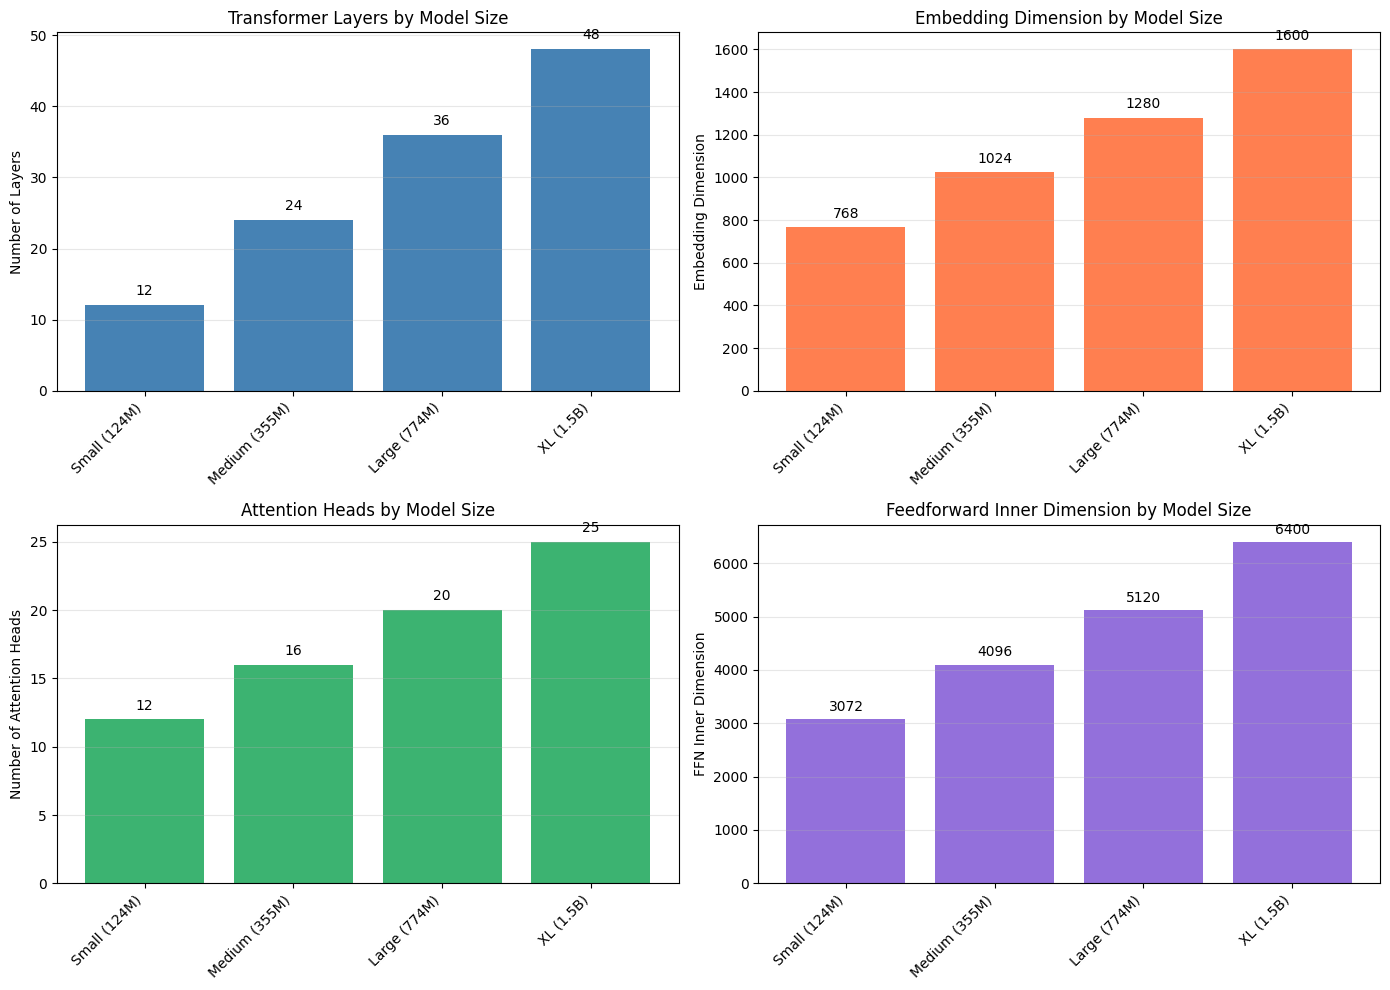

Model size increases through scaling all three dimensions:
  - More layers (depth)
  - Larger embedding dimension (width)
  - More attention heads (parallelism)


In [3]:
# Extract metrics for visualization
model_names = list(configs.keys())
n_layers = [config.n_layer for config in configs.values()]
n_embds = [config.n_embd for config in configs.values()]
n_heads = [config.n_head for config in configs.values()]
n_inners = [config.n_inner for config in configs.values()]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Number of layers
axes[0, 0].bar(range(len(model_names)), n_layers, color='steelblue')
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Layers')
axes[0, 0].set_title('Transformer Layers by Model Size')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(n_layers):
    axes[0, 0].text(i, v + 1, str(v), ha='center', va='bottom')

# Plot 2: Embedding dimension
axes[0, 1].bar(range(len(model_names)), n_embds, color='coral')
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('Embedding Dimension')
axes[0, 1].set_title('Embedding Dimension by Model Size')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(n_embds):
    axes[0, 1].text(i, v + 30, str(v), ha='center', va='bottom')

# Plot 3: Number of heads
axes[1, 0].bar(range(len(model_names)), n_heads, color='mediumseagreen')
axes[1, 0].set_xticks(range(len(model_names)))
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Attention Heads')
axes[1, 0].set_title('Attention Heads by Model Size')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(n_heads):
    axes[1, 0].text(i, v + 0.5, str(v), ha='center', va='bottom')

# Plot 4: FFN inner dimension
axes[1, 1].bar(range(len(model_names)), n_inners, color='mediumpurple')
axes[1, 1].set_xticks(range(len(model_names)))
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].set_ylabel('FFN Inner Dimension')
axes[1, 1].set_title('Feedforward Inner Dimension by Model Size')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(n_inners):
    axes[1, 1].text(i, v + 100, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('Model size increases through scaling all three dimensions:')
print('  - More layers (depth)')
print('  - Larger embedding dimension (width)')
print('  - More attention heads (parallelism)')

## Calculate Parameter Counts

In [4]:
def estimate_parameters(config):
    """Estimate total parameters for a GPT-2 configuration."""
    # Token embeddings
    vocab_params = config.vocab_size * config.n_embd
    
    # Position embeddings
    pos_params = config.n_positions * config.n_embd
    
    # Attention: Q,K,V projection (3 * n_embd * n_embd) + output projection (n_embd * n_embd)
    attn_params = 4 * config.n_embd * config.n_embd
    attn_bias = 4 * config.n_embd  # Biases
    
    # FFN: two linear layers
    ffn_params = 2 * config.n_embd * config.n_inner
    ffn_bias = config.n_embd + config.n_inner  # Biases
    
    # LayerNorm: 2 per layer (ln_1 and ln_2)
    ln_params = 2 * (2 * config.n_embd)  # weight + bias
    
    # Per-layer parameters
    layer_params = attn_params + attn_bias + ffn_params + ffn_bias + ln_params
    total_layer_params = config.n_layer * layer_params
    
    # Final layer norm
    final_ln = 2 * config.n_embd
    
    # Total (note: lm_head shares weights with token embeddings)
    total = vocab_params + pos_params + total_layer_params + final_ln
    
    return {
        'embeddings': vocab_params + pos_params,
        'layers': total_layer_params,
        'final_ln': final_ln,
        'total': total,
    }

# Calculate for all models
print('Parameter Counts (Approximate):')
print('=' * 70)
print(f"{'Model':<20} {'Embeddings':<15} {'Layers':<15} {'Total':<15}")
print('=' * 70)

param_counts = {}
for name, config in configs.items():
    params = estimate_parameters(config)
    param_counts[name] = params['total']
    
    emb_str = f"{params['embeddings']/1e6:.1f}M"
    layers_str = f"{params['layers']/1e6:.1f}M"
    total_str = f"{params['total']/1e6:.1f}M"
    
    print(f"{name:<20} {emb_str:<15} {layers_str:<15} {total_str:<15}")

print('\nNote: Actual counts may vary slightly due to implementation details')

Parameter Counts (Approximate):
Model                Embeddings      Layers          Total          
Small (124M)         39.4M           85.1M           124.4M         
Medium (355M)        52.5M           302.3M          354.8M         
Large (774M)         65.6M           708.4M          774.0M         
XL (1.5B)            82.0M           1475.6M         1557.6M        

Note: Actual counts may vary slightly due to implementation details


## Visualize Parameter Distribution

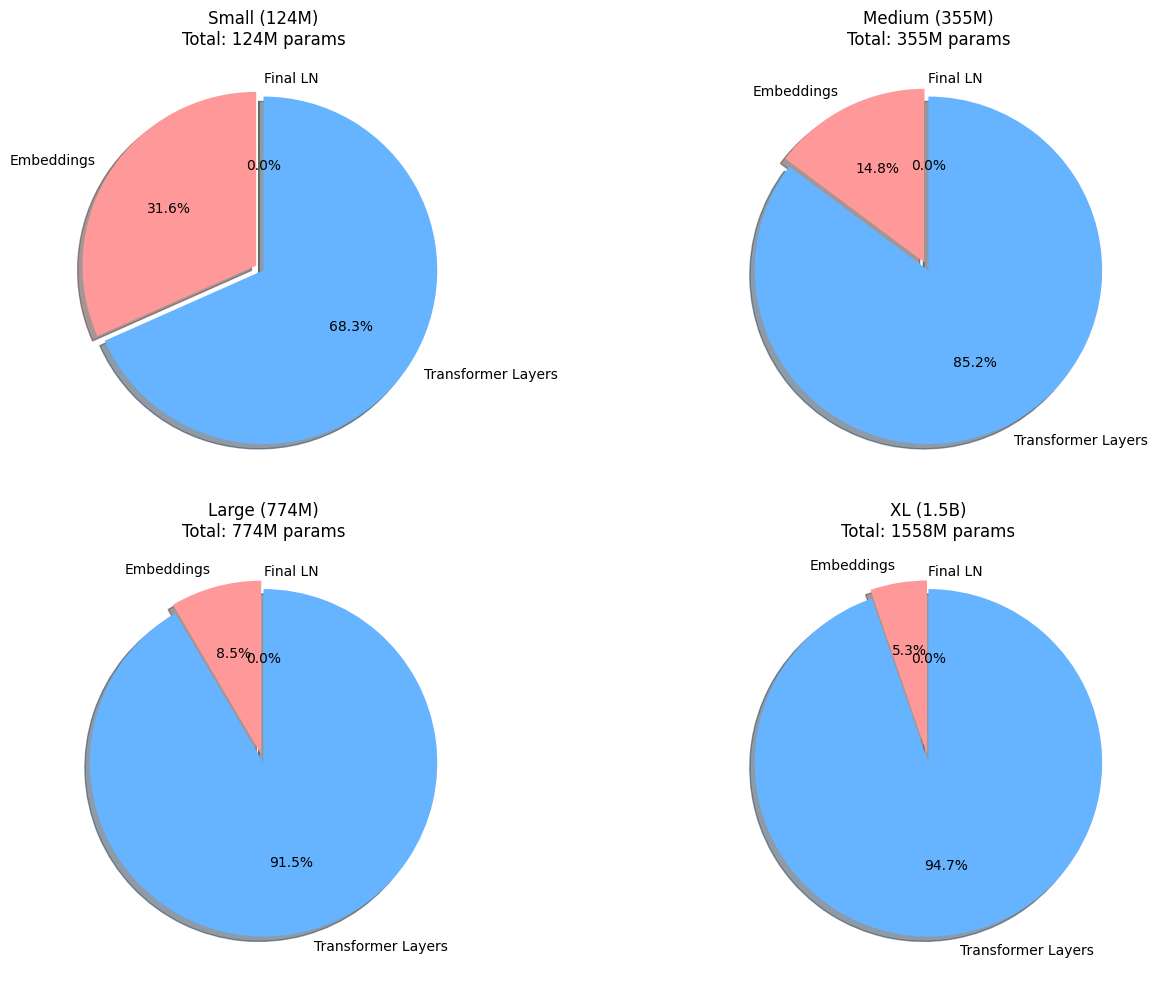

Most parameters are in the transformer layers!
Embeddings are a smaller fraction in larger models


In [5]:
# Calculate parameter breakdown for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, config) in enumerate(configs.items()):
    params = estimate_parameters(config)
    
    # Create pie chart
    sizes = [params['embeddings'], params['layers'], params['final_ln']]
    labels = ['Embeddings', 'Transformer Layers', 'Final LN']
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    explode = (0.05, 0, 0)
    
    axes[idx].pie(sizes, explode=explode, labels=labels, colors=colors,
                  autopct='%1.1f%%', shadow=True, startangle=90)
    axes[idx].set_title(f'{name}\nTotal: {params["total"]/1e6:.0f}M params')

plt.tight_layout()
plt.show()

print('Most parameters are in the transformer layers!')
print('Embeddings are a smaller fraction in larger models')

## Compare Head Dimensions

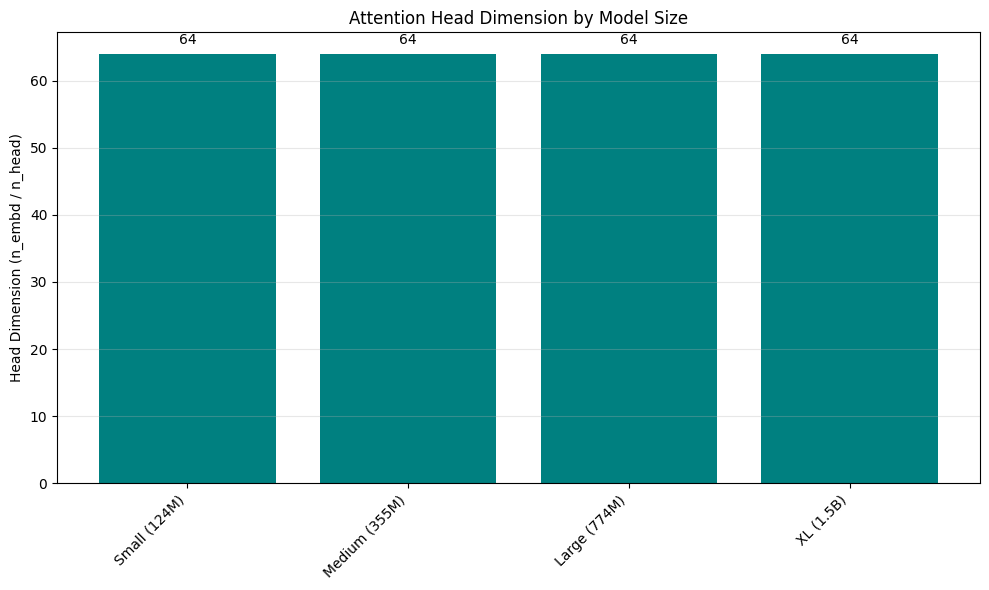

Head dimension: n_embd // n_head

Head dimensions for each model:
  Small (124M): 64
  Medium (355M): 64
  Large (774M): 64
  XL (1.5B): 64

All head dimensions are 64! This is a design choice for consistency.


In [6]:
# Calculate head dimension for each model
head_dims = [config.n_embd // config.n_head for config in configs.values()]

plt.figure(figsize=(10, 6))
plt.bar(range(len(model_names)), head_dims, color='teal')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.ylabel('Head Dimension (n_embd / n_head)')
plt.title('Attention Head Dimension by Model Size')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(head_dims):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('Head dimension: n_embd // n_head')
print('\nHead dimensions for each model:')
for name, head_dim in zip(model_names, head_dims):
    print(f'  {name}: {head_dim}')
print('\nAll head dimensions are 64! This is a design choice for consistency.')

## Create Custom Configuration

In [7]:
# Create a custom tiny model for experimentation
tiny = GPT2Config(
    n_embd=256,
    n_layer=6,
    n_head=8,
    n_positions=512,  # Shorter context
)

print('Custom Tiny GPT-2 Configuration:')
print(f'  Layers: {tiny.n_layer}')
print(f'  Embedding dim: {tiny.n_embd}')
print(f'  Attention heads: {tiny.n_head}')
print(f'  Head dimension: {tiny.n_embd // tiny.n_head}')
print(f'  FFN inner dim: {tiny.n_inner}')
print(f'  Context length: {tiny.n_positions}')
print(f'  Vocabulary: {tiny.vocab_size:,}')

tiny_params = estimate_parameters(tiny)
print(f'\nEstimated parameters: {tiny_params["total"]/1e6:.1f}M')
print('\nThis tiny model is great for fast experimentation!')

Custom Tiny GPT-2 Configuration:
  Layers: 6
  Embedding dim: 256
  Attention heads: 8
  Head dimension: 32
  FFN inner dim: 1024
  Context length: 512
  Vocabulary: 50,257

Estimated parameters: 17.7M

This tiny model is great for fast experimentation!


## Verify Configuration Validation

In [8]:
# Test that validation works
print('Testing configuration validation:\n')

# Valid configuration
try:
    config = GPT2Config(n_embd=768, n_head=12)
    print('✓ Valid config (768 ÷ 12 = 64): Success')
except AssertionError as e:
    print(f'✗ Unexpected error: {e}')

# Invalid configuration: n_embd not divisible by n_head
try:
    config = GPT2Config(n_embd=770, n_head=12)
    print('✗ Invalid config (770 ÷ 12 = 64.16...) should have failed!')
except AssertionError as e:
    print(f'✓ Invalid config correctly rejected: {e}')

print('\nValidation ensures n_embd is always divisible by n_head!')

Testing configuration validation:

✓ Valid config (768 ÷ 12 = 64): Success
✓ Invalid config correctly rejected: n_embd (770) must be divisible by n_head (12)

Validation ensures n_embd is always divisible by n_head!


## Verify Your Implementation

In [9]:
# Quick verification
config = GPT2Config()

print('✓ GPT2Config implemented')
print('✓ All parameters stored correctly')
print('✓ Validation working (n_embd divisible by n_head)')
print('✓ Computed n_inner = 4 * n_embd')
print('✓ All four preset configurations available')
print('\n✅ Configuration class complete!')
print('\nRun "uv run pytest test_config.py -v" for complete validation.')

✓ GPT2Config implemented
✓ All parameters stored correctly
✓ Validation working (n_embd divisible by n_head)
✓ Computed n_inner = 4 * n_embd
✓ All four preset configurations available

✅ Configuration class complete!

Run "uv run pytest test_config.py -v" for complete validation.
